# Square Root Approximation of the Fokker-Planck Equation

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

from sqra_functions import generate_random_points, clip_voronoi, find_common_edge

from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point
from scipy.cluster.vq import kmeans
from scipy.spatial import ConvexHull
import alphashape

import sympy as sp

from pcca import pcca


font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

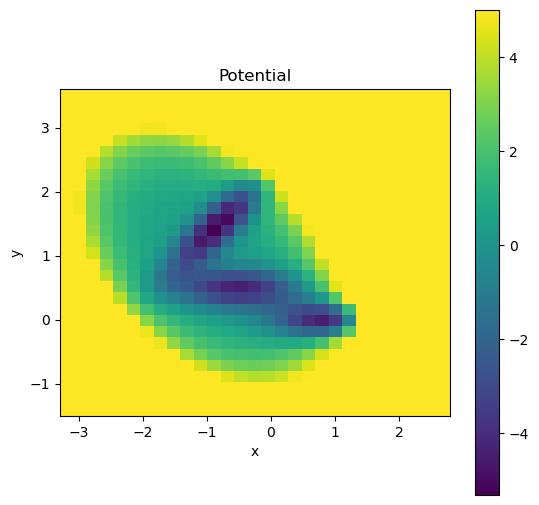

In [2]:
# Parameter Lambda 
L   =  0.5

# Muller Brown coefficients
# The coefficients in position [0] and [1] are used by Va
# The coefficients in position [2] and [3] are used by Vb

#A   =  np.array([-20, -10,  -17, 1.5])
A   =  np.array([-18, -10,  -12, 1])

a   =  np.array([ -1,  -1, -6.5, 0.7])
b   =  np.array([  0,   0,   11, 0.6])
c   =  np.array([-10, -10, -6.5, 0.7])
#x0  =  np.array([  1,   0, -0.5,  -1])
x0  =  np.array([  1.2,   -0.5, -0.8,  -1])
y0  =  np.array([  0, 0.5,  1.5,   1])

# Initialize the variables x and y for symbolic calculation
x,y   =  sp.symbols('x,y')

# Define the potentials Va, Vb and V with sympy
Va    =  A[0] * sp.exp(a[0]*(x - x0[0])**2 + b[0]*(x - x0[0])*(y - y0[0]) + c[0]*(y - y0[0])**2) + \
         A[1] * sp.exp(a[1]*(x - x0[1])**2 + b[1]*(x - x0[1])*(y - y0[1]) + c[1]*(y - y0[1])**2)

Vb    =  A[2] * sp.exp(a[2]*(x - x0[2])**2 + b[2]*(x - x0[2])*(y - y0[2]) + c[2]*(y - y0[2])**2) + \
         A[3] * sp.exp(a[3]*(x - x0[3])**2 + b[3]*(x - x0[3])*(y - y0[3]) + c[3]*(y - y0[3])**2)
                                                          
V = L * Va + ( 1 - L ) * Vb

# Calculate gradient with sympy
gradVx  =  V.diff(x)
gradVy  =  V.diff(y)

# To display sympy functions:
# display(gradVx)
# display(gradVy)

# Convert potential and gradient in numpy functions
V       =  sp.lambdify((x,y), V, modules=['numpy'])
gradVx  =  sp.lambdify((x,y), gradVx, modules=['numpy'])
gradVy  =  sp.lambdify((x,y), gradVy, modules=['numpy'])

# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
mass  = 1           # amu
gamma = 1           # ps-1

D     = kB * T / mass / gamma # nm2 ps-1
sigma = np.sqrt(2 * D)
beta  = 1 / kB / T

# Grid
nd     =  2  # Number of dimensions
xbins  = 30  # x boundaries
xmin   = -3.3
xmax   =  2.8

ybins  = 30  # y boundaries
ymin   = -1.5
ymax   =  3.6


xedges = np.linspace(xmin, xmax, xbins)  # array with x edges
dx     = xedges[1] - xedges[0]
x      = xedges[:-1] + (dx / 2)                # array with x centers
xbins  = xbins - 1

yedges = np.linspace(ymin, ymax, ybins)  # array with y edges
dy     = yedges[1] - yedges[0]
y      = yedges[:-1] + (dy / 2)                # array with y centers
ybins  = ybins - 1

Nbins  = xbins*ybins                      # number of bins

grid = np.meshgrid(x,y)


fig, ax1 = plt.subplots(1, 1,figsize=(16*in2cm, 16*in2cm))  

pos = ax1.pcolor(grid[0], grid[1], V(grid[0], grid[1]), shading='auto', vmax=5)
ax1.set_title('Potential')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(pos, ax=ax1)

## Create Voronoi tessellation

In [3]:
# Generate random points
n_points = 10000
n_cells  = 300
xlim = (-2.6, 1.5)
ylim = (-0.8, 2.6)
points = generate_random_points(n_points, n_cells, xlim, ylim, V, 1.5)

# Find the convex hull
hull = ConvexHull(points)

# PERIMETER OF THE CONVEX HULL
# Get the indices of the points on the perimeter
#
# perimeter_indices = hull.vertices
#
# Extract the points on the perimeter
# perimeter_points = points[perimeter_indices]
# perimeter_points = np.append(perimeter_points, [perimeter_points[0,:]], axis=0)

# PERIMETER OF THE CONCAVE HULL
# Extract the vertices of the convex hull
hull_vertices = points[hull.vertices]

# Define an appropriate alpha value for concave hull
alpha = 4

# Calculate the concave hull using alpha shape
concave_hull = alphashape.alphashape(points, alpha)

# Retrieve the coordinates of the points forming the concave hull
perimeter_points = np.array(list(concave_hull.exterior.coords))


perimeter_points = np.append(perimeter_points, [perimeter_points[0,:]], axis=0)


277


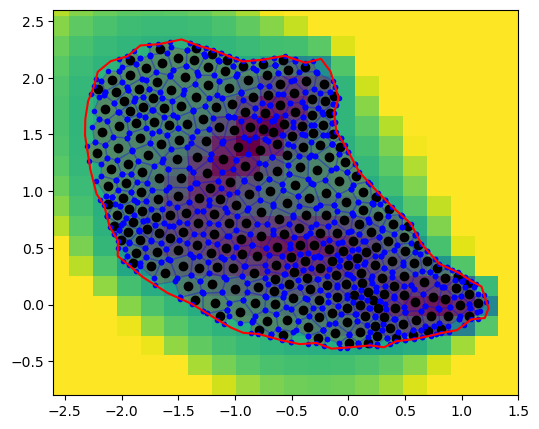

In [4]:
# Compute Voronoi tessellation
vor = Voronoi(points)
print(vor)
# Define the boundary polygon
boundary_coords  = perimeter_points
boundary_polygon = Polygon(boundary_coords)
# Clip Voronoi tessellation by the boundary polygon
clipped_regions = clip_voronoi(vor, boundary_polygon)

# Plot the Voronoi tessellation and clipped regions
fig, ax = plt.subplots(figsize=(6, 6))
#voronoi_plot_2d(vor, ax=ax)
plt.pcolor(grid[0], grid[1], V(grid[0], grid[1]), shading='auto', vmax=5)

# Number of cells after clipping
Ncells = len(clipped_regions)
print(Ncells)




# Plot the clipped regions
for region in clipped_regions:
    polygon = Polygon(region)
    
    plt.plot(polygon.centroid.xy[0], polygon.centroid.xy[1], 'ko')
    plt.plot(polygon.boundary.xy[0], polygon.boundary.xy[1], 'b.')
    plt.fill(*polygon.exterior.xy, alpha=0.2, fc='r', ec='b')

plt.plot(boundary_polygon.boundary.xy[0], boundary_polygon.boundary.xy[1],'r')

ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.set_aspect('equal')
plt.show()

## Adjaceny matrix

Adjacency matrix is generated searching Voronoi cells sharing the same vertices.
The same script is using to estimate the matrix $\mathcal{S}_{ij}$ with the intersecting surfaces and the matrix $h_{ij}$ distance between adjacent points.

In [5]:
# Volumes    
Vol      = np.zeros(Ncells)

# Cell centers    
cell_centers  = np.zeros((Ncells,2))

# Adjacency matrix
A      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Intersecting areas
S      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Distances between neighboring points 
h      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Note that len(vor.filtered_regions) = Ncells

# region = Voronoi cell
for i in range(Ncells):
    
    cell_i   = Polygon(clipped_regions[i])
    
    Vol[i]   = cell_i.area
    
    # Coordinates of the cells centers
    v0_x       = cell_i.centroid.xy[0][0]
    v0_y       = cell_i.centroid.xy[1][0]
    
    cell_centers[i,:] = [v0_x, v0_y]

    
    for j in range(i+1, Ncells):
        
        cell_j   = Polygon(clipped_regions[j])
        
        int_sur = cell_i.intersects(cell_j)

        # if two cells share vertices, 
        if int_sur == True:
            
            # then they are adjacent:
            A[i,j] = 1
            A[j,i] = 1
            
            # Coordinates of the cells centers
            v1_x       = cell_j.centroid.xy[0][0]
            v1_y       = cell_j.centroid.xy[1][0]
            
            # Distance between the centers
            distance = np.sqrt( ( v1_x - v0_x )**2 + ( v1_y - v0_y )**2 )
            h[i,j]   = distance
            h[j,i]   = distance
            
            # Coordinates of the intersecting vertices
            edge1_start, edge1_end = find_common_edge(cell_i, cell_j)
            int_sur0_x = edge1_start[0]
            int_sur0_y = edge1_start[1]
            int_sur1_x = edge1_end[0]
            int_sur1_y = edge1_end[1]
                        
            # Intersecting area (length of the common edge)
            area = np.sqrt( ( int_sur1_x - int_sur0_x )**2 + ( int_sur1_y - int_sur0_y )**2 )
            S[i,j] = area
            S[j,i] = area
            

## SqRA

$$
\pi(x,y) = \exp(-\beta V(x,y))
$$

$$
Q_{ij} = D \frac{\mathcal{S}_{ij}}{\mathcal{V}_i h_{ij}} \sqrt{\frac{\pi_j}{\pi_i}}
$$

In [6]:
# Boltzmann distribution
pi   = np.exp(-beta * V(cell_centers[:,0], cell_centers[:,1]))
sqra = np.sqrt(pi)

Q = scipy.sparse.lil_matrix((Ncells, Ncells))

for i in range(Ncells):
    for j in range(Ncells):
        if A[i,j] == 1:
            Q[i,j] = D * S[i,j] / Vol[i] / h[i,j] * sqra[j] / sqra[i]
            
# The diagonal is equal to minus the row-sum
Q    = Q + scipy.sparse.spdiags( - Q.sum(axis=1).T, 0, Ncells, Ncells)

## Eigenvalue problem
Estimate left eigenvectors and eigenvalues:

$$
Q \varphi_i(x) = \lambda_i \varphi_i(x)
$$

In [7]:
# Number of eigenvectors
Nevecs = 10

# Eigenvalue problem
evals, evecs = scipy.sparse.linalg.eigs(Q.T, Nevecs, which='LR')
evals = np.real(evals)
evecs = np.real(evecs)
evecs[:,0] = np.abs(evecs[:,0])

e0 = np.real(evecs[:,0])
e1 = np.real(evecs[:,1])
e2 = np.real(evecs[:,2])


Text(0.5, 1.0, 'Eigenvalues')

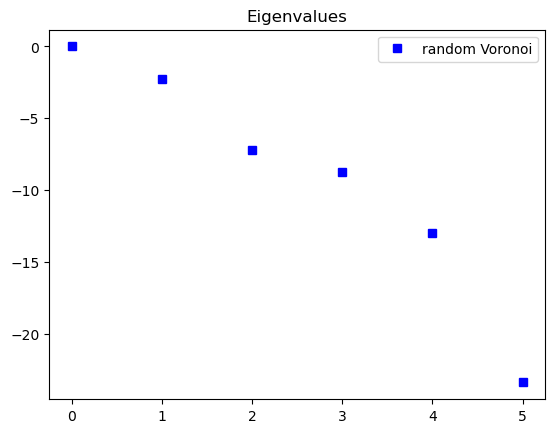

In [8]:
plt.plot(evals[0:6],'bs', label = 'random Voronoi')
plt.legend()
plt.title('Eigenvalues')

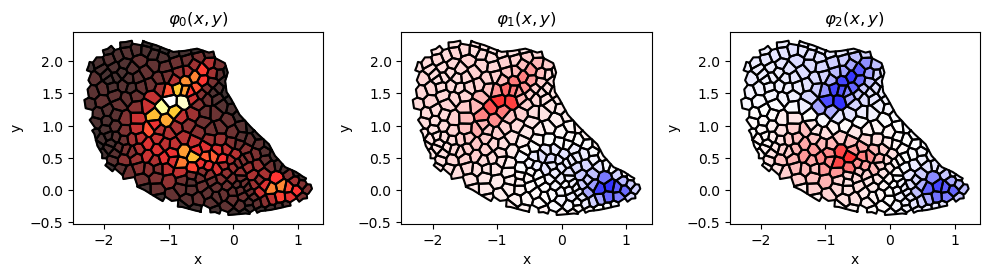

In [9]:
#
# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=np.min(e0), vmax=np.max(e0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)


fig, (ax) = plt.subplots(1, 3, figsize=(10,10))


# normalize chosen colormap
norm   = mpl.colors.Normalize(vmin=np.min(e0), vmax=np.max(e0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

    
for i,region in enumerate(clipped_regions):
    polygon = Polygon(region)
    #ax[0,0].plot(polygon.centroid.xy[0], polygon.centroid.xy[1], 'ko')
    ax[0].plot(polygon.boundary.xy[0], polygon.boundary.xy[1], 'k-')
    ax[0].fill(*polygon.exterior.xy, alpha=0.8, color=mapper.to_rgba(e0[i]));
    ax[0].set_aspect('equal', 'box')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title(r'$\varphi_0(x,y)$')
    
    
    
norm = mpl.colors.Normalize(vmin=np.min(e1), vmax=np.max(e1), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(clipped_regions):
    polygon = Polygon(region)
    #ax[0,0].plot(polygon.centroid.xy[0], polygon.centroid.xy[1], 'ko')
    ax[1].plot(polygon.boundary.xy[0], polygon.boundary.xy[1], 'k-')
    ax[1].fill(*polygon.exterior.xy, alpha=0.8, color=mapper.to_rgba(e1[i]));
    ax[1].set_aspect('equal', 'box')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].set_title(r'$\varphi_1(x,y)$')
    
    
norm = mpl.colors.Normalize(vmin=np.min(e2), vmax=np.max(e2), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(clipped_regions):
    polygon = Polygon(region)
    #ax[0,0].plot(polygon.centroid.xy[0], polygon.centroid.xy[1], 'ko')
    ax[2].plot(polygon.boundary.xy[0], polygon.boundary.xy[1], 'k-')
    ax[2].fill(*polygon.exterior.xy, alpha=0.8, color=mapper.to_rgba(e2[i]));
    ax[2].set_aspect('equal', 'box')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')
    ax[2].set_title(r'$\varphi_2(x,y)$')
    
fig.tight_layout();

In [10]:
# Dense matrix
Qd = Q.toarray()

chi, e, S, X = pcca(Qd, 3, massmatrix=None)
Qc = np.linalg.pinv(chi).dot(Qd.dot(chi))

chi1 = chi[:,0]
chi2 = chi[:,1]
chi3 = chi[:,2]

print(Qc)

Optimization terminated successfully.
         Current function value: -194.933586
         Iterations: 256
         Function evaluations: 444
[[-1.99102008  2.25826602 -0.26724593]
 [ 1.5538834  -4.83277808  3.27889468]
 [ 0.27417736  2.38973598 -2.66391334]]


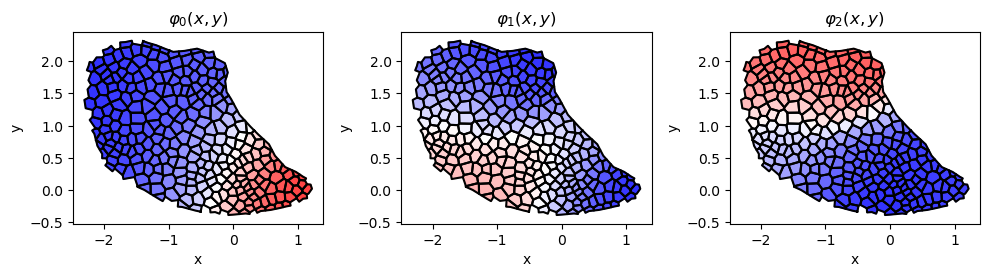

In [11]:
#
# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=np.min(e0), vmax=np.max(e0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)


fig, (ax) = plt.subplots(1, 3, figsize=(10,10))


# normalize chosen colormap
norm   = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

    
for i,region in enumerate(clipped_regions):
    polygon = Polygon(region)
    #ax[0,0].plot(polygon.centroid.xy[0], polygon.centroid.xy[1], 'ko')
    ax[0].plot(polygon.boundary.xy[0], polygon.boundary.xy[1], 'k-')
    ax[0].fill(*polygon.exterior.xy, alpha=0.8, color=mapper.to_rgba(chi1[i]));
    ax[0].set_aspect('equal', 'box')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title(r'$\varphi_0(x,y)$')
    
    
    
norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(clipped_regions):
    polygon = Polygon(region)
    #ax[0,0].plot(polygon.centroid.xy[0], polygon.centroid.xy[1], 'ko')
    ax[1].plot(polygon.boundary.xy[0], polygon.boundary.xy[1], 'k-')
    ax[1].fill(*polygon.exterior.xy, alpha=0.8, color=mapper.to_rgba(chi2[i]));
    ax[1].set_aspect('equal', 'box')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].set_title(r'$\varphi_1(x,y)$')
    
    
norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(clipped_regions):
    polygon = Polygon(region)
    #ax[0,0].plot(polygon.centroid.xy[0], polygon.centroid.xy[1], 'ko')
    ax[2].plot(polygon.boundary.xy[0], polygon.boundary.xy[1], 'k-')
    ax[2].fill(*polygon.exterior.xy, alpha=0.8, color=mapper.to_rgba(chi3[i]));
    ax[2].set_aspect('equal', 'box')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')
    ax[2].set_title(r'$\varphi_2(x,y)$')
    
fig.tight_layout();

In [12]:
Qc

array([[-1.99102008,  2.25826602, -0.26724593],
       [ 1.5538834 , -4.83277808,  3.27889468],
       [ 0.27417736,  2.38973598, -2.66391334]])